In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import randint
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelPropagation
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

In [3]:
data = pd.read_csv('D:/LabelNoise/SPECT.train',header=None)     #label Column is 0

In [4]:
def model_accuracy(df,model,label):
    m = model()
    features = df.loc[:,df.columns!=label]
    label = df[label]
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.38)
    m.fit(x_train,y_train)
    return m.score(x_test,y_test)

In [18]:
models = [SVC,RandomForestClassifier,GaussianNB,LogisticRegression,DecisionTreeClassifier]
acc = pd.DataFrame()
for model in models:
    result = model_accuracy(data,model,0)
    acc = acc.append(pd.Series(model_accuracy(data,model,0)),ignore_index=True)
acc.columns = ['Accuracy']    
acc['model'] = pd.Series(["SVC","Random Forest","Naive Bayes","Logistic Regression","Decision Tree"])                     

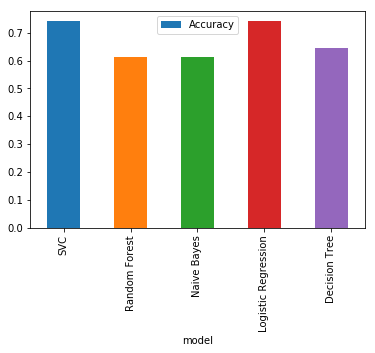

In [27]:
acc.plot(x='model',y='Accuracy',kind='bar')

> Adding Noise

In [32]:
data['Original_label'] = data[0]
class0 = data.loc[data[0]!=1,:]
class1 = data.loc[data[0]!=0,:]
def noise(data):
    sample = data.sample(frac = 0.3)
    for i in list(sample.index):
        data[0][i] = int(not data[0][i])
    return list(sample.index)    
noise0 = noise(class0)
noise1 = noise(class1)
noisy_indices = noise0+noise1
mislabeled = pd.concat([class0,class1])
indices = list(mislabeled.index)     

> Ensemble Learning

In [33]:
features = mislabeled.loc[:,data.columns!=0]
label = mislabeled[0]
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size = 0.38)

In [38]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
predict = lr.predict(features)
predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [39]:
svm = SVC()
svm.fit(x_train,y_train)
predict = svm.predict(features)
# predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [40]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
predict = dt.predict(features)
# predicted = defaultdict(list)
for i in range(len(indices)):
    predicted[indices[i]].append(predict[i])    

In [41]:
predicted

defaultdict(list,
            {40: [1, 0, 0],
             41: [0, 0, 0],
             42: [0, 0, 0],
             43: [0, 0, 0],
             44: [0, 0, 0],
             45: [0, 0, 1],
             46: [0, 0, 1],
             47: [0, 0, 1],
             48: [0, 0, 0],
             49: [1, 0, 1],
             50: [0, 0, 0],
             51: [0, 0, 0],
             52: [0, 0, 0],
             53: [0, 0, 0],
             54: [1, 0, 1],
             55: [0, 0, 0],
             56: [0, 0, 1],
             57: [0, 0, 0],
             58: [0, 0, 0],
             59: [0, 0, 0],
             60: [0, 0, 0],
             61: [0, 0, 0],
             62: [1, 0, 0],
             63: [0, 0, 0],
             64: [0, 0, 0],
             65: [0, 0, 0],
             66: [1, 0, 0],
             67: [0, 0, 0],
             68: [0, 0, 0],
             69: [0, 0, 0],
             70: [0, 0, 1],
             71: [0, 0, 0],
             72: [0, 0, 0],
             73: [0, 0, 1],
             74: [0, 0, 0],
  